# Two Object CNN Model 

## Libraries

In [2]:
import tensorflow as tf
# from tensorflow.keras import layers
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader


## Functions

In [3]:

# Define a function to calculate the output size after a convolution or pooling layer
def conv2d_output_size(input_size, kernel_size, padding=0, stride=1):
    output_size = (input_size - kernel_size + 2*padding) // stride + 1
    return output_size

# Define a function to calculate the size after a sequence of convolution and pooling
def calculate_conv_output_size(input_size, *layers):
    size = input_size
    for layer in layers:
        if isinstance(layer, nn.Conv2d):
            size = conv2d_output_size(size, layer.kernel_size[0], padding=layer.padding[0], stride=layer.stride[0])
        elif isinstance(layer, nn.MaxPool2d):
            size = conv2d_output_size(size, layer.kernel_size, padding=layer.padding, stride=layer.stride)
    return size

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_loader)}')

In [4]:
def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    if label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    if spatial_label == "above right":
        label_1, label_2 = label_2, label_1
        spatial_label = "below left"
    elif spatial_label == "above left":
        label_1, label_2 = label_2, label_1
        spatial_label = "below right"
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1,y1,x2,y2):
    
    if y1 == y2:
        label = "left"
    elif x1 == x2:
        label = "above"
    elif x1< x2 and y1 < y2:
        label = "above left"
    elif x1 > x2 and y1 < y2:
        label = "above right"
    else:
        label = "below left"
    return label

In [5]:
def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    # creates a number of images containing three random items from FashionMNIST dataset with two vectors of 10 binary values, 
    # which encode names of the two items in the image and their spatial relation, and the name of the spatial relation between
    # the two items 
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while True:
            if label_1 == label_2:
                idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img2, label_2 = train_loader.dataset[idx2]
                continue
            else:
                break

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)

        if a >= 0:
            x1 = a
            y1 = 0
        else:
            x1 = 0
            y1 = abs(a)
        
        if x1 > 0 and y1 == 0:
            y2 = 27
            x2 = np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2 = b
                y2 = 27
            else:
                x2 = 27
                y2 = 55 - b
        else:
            x2 = 27
            y2 = np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        spatial_label = spatial_relation_labels(x1,y1,x2,y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, vector))

    return samples

In [6]:
def transform_loader(data_loader, num_samples=None):
    # Set num_samples to the size of the dataset if not specified
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    
    # Transform the data using your existing function
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    
    # Return the transformed data
    return transformed_data

## Loading Data

In [7]:
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split
import os
from argparse import Namespace as SimpleNamespace

# Arguments
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)

# Use CUDA if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=True, 
    download=True, 
    transform=transformation
)
full_test_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=False, 
    download=True, 
    transform=transformation
)

# Combine train and test datasets
full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])

# Set the manual seed for reproducibility
torch.manual_seed(args.seed)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.64 * total_size)
val_size = int(0.16 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# Define data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Check proportions
print(f'Train data is {100 * len(train_dataset) / total_size}% of the dataset')
print(f'Val data is {100 * len(val_dataset) / total_size}% of the dataset')
print(f'Test data is {100 * len(test_dataset) / total_size}% of the dataset')


Train data is 64.0% of the dataset
Val data is 16.0% of the dataset
Test data is 20.0% of the dataset


# Preprocessing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


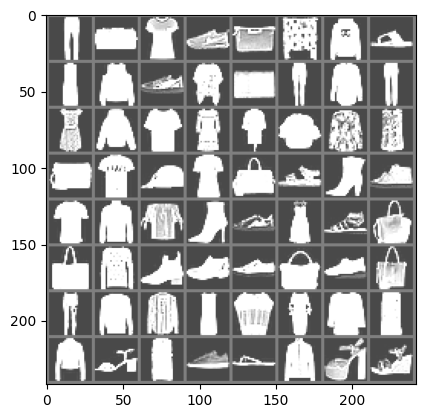

Labels:  [1, 8, 0, 7, 8, 6, 2, 5, 6, 2, 7, 6, 8, 1, 6, 1, 3, 4, 0, 3, 4, 8, 6, 0, 8, 0, 8, 0, 8, 5, 9, 7, 0, 4, 6, 9, 7, 3, 5, 8, 8, 2, 9, 9, 7, 8, 7, 8, 1, 2, 6, 3, 6, 3, 0, 0, 4, 5, 0, 7, 5, 4, 5, 5]


In [8]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next() to fetch the next batch

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels: ', labels.tolist())


In [9]:
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

## Examples

Example nr 1: 
Input: 


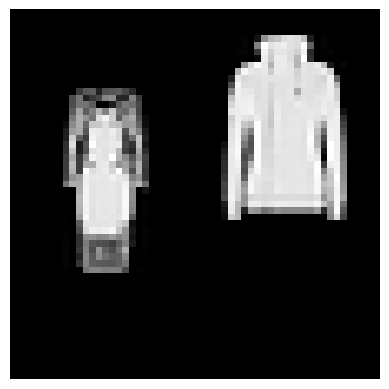

Output:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] 

Example nr 2: 
Input: 


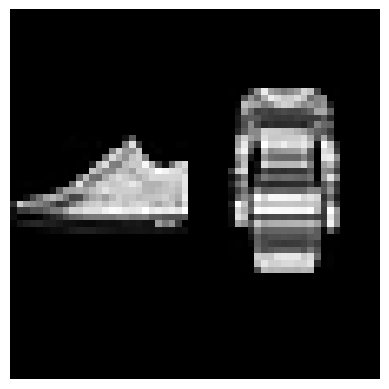

Output:  [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0] 

Example nr 3: 
Input: 


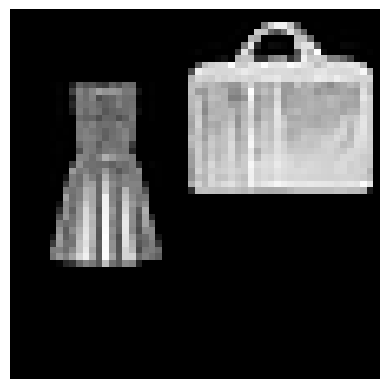

Output:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0] 



In [10]:
for i in range(3):
    img, vector = train_data[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", vector,"\n")   

Example nr 1: 
Input: 


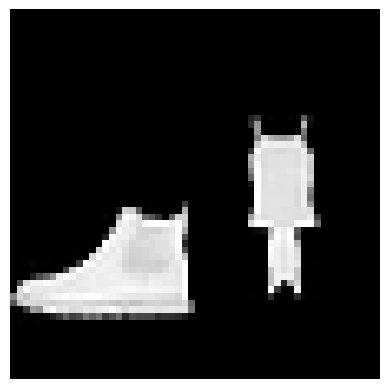

Output:  [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0] 

Example nr 2: 
Input: 


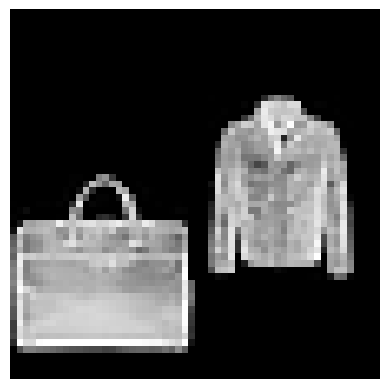

Output:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] 

Example nr 3: 
Input: 


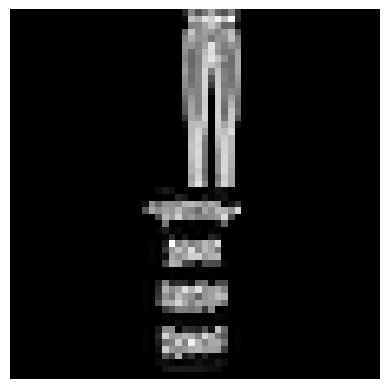

Output:  [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0] 

Example nr 4: 
Input: 


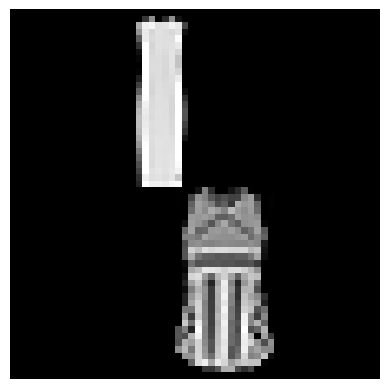

Output:  [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1] 

Example nr 5: 
Input: 


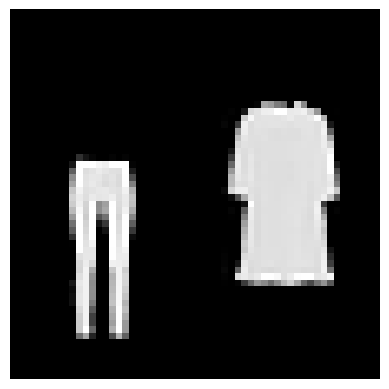

Output:  [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0] 



In [11]:
samples = create_samples_with_non_overlapping_images_and_vectors(test_loader,5)

for i in range(5):
    img, vector = samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", vector,"\n")    

# THE TWO OBJECT MODEL 

## Our Hiperparameters should look like this:

In [10]:
# number of Filters: This determines the number of output channels in each convolutional layer (i.e., the depth of the feature maps). Common choices are 32, 64, and 128.
# Kernel Size: The size of the filter that will convolve around the input volume. Common sizes are 3x3, 5x5, and 11x11.
# Optimizer: This is the algorithm used to update the weights of the network. Adam and Stochastic Gradient Descent (SGD) are two commonly used optimizers.
# Learning Rate (LR): This is a hyperparameter that controls the amount by which the weights are updated during training. Common starting values are 0.01, 0.001, and 0.0001.
# LR Decay: Whether to use learning rate decay, which reduces the learning rate over time.
# Batch Size: The number of training samples used in one iteration. Options here include 1 (stochastic), 32, 64, or using the full dataset (batch gradient descent).
# Dropout: A regularization technique that involves randomly setting a fraction of input units to 0 at each update during training to prevent overfitting. Common values are 0.2, 0.3, 0.4, and 0.5.

import pandas as pd

# Define the hyperparameters and their corresponding options and search methods
hyperparameters = {
    "Hyperparameter": [
        "Number of filters",
        "Kernel size",
        "Optimiser",
        "Learning rate",
        "LR Decay",
        "Batch size",
        "Dropout"
    ],
    "Options": [
        "32, 64, 128",
        "3 x 3, 5 x 5, 11 x 11",
        "Adam, SGD",
        "0.01, 0.001, 0.0001",
        "Yes, No",
        "1, 32, 64, full",
        "0.2, 0.3, 0.4, 0.5"
    ],
    "Search": [
        "H",
        "M",
        "H",
        "M",
        "M",
        "M",
        "M"
    ]
}

# Create a DataFrame
df_hyperparameters = pd.DataFrame(hyperparameters)

# Print the table
print(df_hyperparameters.to_string(index=False))



   Hyperparameter               Options Search
Number of filters           32, 64, 128      H
      Kernel size 3 x 3, 5 x 5, 11 x 11      M
        Optimiser             Adam, SGD      H
    Learning rate   0.01, 0.001, 0.0001      M
         LR Decay               Yes, No      M
       Batch size       1, 32, 64, full      M
          Dropout    0.2, 0.3, 0.4, 0.5      M


In [11]:
class SpatialRelationCNN(nn.Module):
    def __init__(self):
        super(SpatialRelationCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers for processing the convolutional outputs
        self.fc_label_a = nn.Linear(14*14*64, 64)
        self.fc_label_b = nn.Linear(14*14*64, 64)

        # Concatenate the outputs of the two branches
        self.fc1_concatenated = nn.Linear(64 + 64, 512)

        # Output layer
        self.fc_output = nn.Linear(512, 24)  # Adjusted to match your target vector size

    def forward(self, x):
        # Apply the first set of layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Apply the second set of layers
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Flatten the convolutional layer outputs
        x_flattened = x.view(x.size(0), -1)

        # Apply the fully connected layers to each branch
        label_a_out = F.relu(self.fc_label_a(x_flattened))
        label_b_out = F.relu(self.fc_label_b(x_flattened))

        # Concatenate the outputs
        concatenated = torch.cat((label_a_out, label_b_out), dim=1)

        # Apply the last fully connected layers
        concatenated = F.relu(self.fc1_concatenated(concatenated))
        x_output = self.fc_output(concatenated)
        
        return x_output

### RNA

In [12]:
class ControllerNetwork(nn.Module):
    def __init__(self):
        super(ControllerNetwork, self).__init__()
        self.fc1 = nn.Linear(24 + 24, 128)  # Taking the prediction and adaptation signal as input
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 24) 

    def forward(self, prediction, adaptation_signal):
        if adaptation_signal.dim() == 1:
            adaptation_signal = adaptation_signal.unsqueeze(1)
        x = torch.cat((prediction, adaptation_signal), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class AdaptableSpatialRelationCNN(nn.Module):
    def __init__(self):
        super(AdaptableSpatialRelationCNN, self).__init__()
        self.main_network = SpatialRelationCNN()
        self.controller_network = ControllerNetwork()

    def forward(self, x, adaptation_signal):
        prediction = self.main_network(x)
        adjustment = self.controller_network(prediction, adaptation_signal)
        adjusted_prediction = prediction + adjustment 
        return adjusted_prediction


rna + szumy

In [42]:
def add_uniform_noise(images, noise_level=0.1, num_noisy_pixels=500):
    noisy_images = images.clone()
    for img in noisy_images:
        c, h, w = img.shape
        total_pixels = h * w
        random_indices = torch.randperm(total_pixels)[:num_noisy_pixels]
        noise = torch.rand(num_noisy_pixels) * noise_level
        img.view(-1)[random_indices] += noise
    return noisy_images.clamp(0, 1)

In [14]:
from torch.distributions import Categorical

def calculate_entropy(probs):
    dist = Categorical(probs)
    entropy = dist.entropy()
    return entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdaptableSpatialRelationCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_images = torch.stack([item[0] for item in train_data])
# train_images = add_uniform_noise(train_images)
train_vectors = torch.stack([torch.tensor(item[1]) for item in train_data])

batch_size = 64
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    adaptation_signals = []

    for inputs, labels in DataLoader(TensorDataset(train_images, train_vectors), batch_size=batch_size, shuffle=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.main_network(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = torch.sigmoid(outputs).detach().cpu()
        entropy = calculate_entropy(probs)
        adaptation_signals.append(entropy)

    adaptation_signals = torch.cat(adaptation_signals).to(device)
    adaptation_signals = adaptation_signals.unsqueeze(1).repeat(1, 24)
    train_dataset = TensorDataset(train_images, train_vectors, adaptation_signals)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for inputs, labels, adaptation_signal in train_loader:
        inputs, labels, adaptation_signal = inputs.to(device), labels.to(device), adaptation_signal.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, adaptation_signal)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')

model_path = 'adaptable_spatial_relation_cnn.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/50, Loss: 0.00450605084155021
Epoch 2/50, Loss: 0.0028599409806442312
Epoch 3/50, Loss: 0.0020675173049676233
Epoch 4/50, Loss: 0.0014569866355408781
Epoch 5/50, Loss: 0.0009704165392031427
Epoch 6/50, Loss: 0.0006389120968170963
Epoch 7/50, Loss: 0.0004620699474045458
Epoch 8/50, Loss: 0.0003427766762589662
Epoch 9/50, Loss: 0.0002817886042586386
Epoch 10/50, Loss: 0.0002389215020333982
Epoch 11/50, Loss: 0.00021531025554915166
Epoch 12/50, Loss: 0.00019820709943295308
Epoch 13/50, Loss: 0.00019855771355845977
Epoch 14/50, Loss: 0.00015975279070809328
Epoch 15/50, Loss: 0.00014096524072848687
Epoch 16/50, Loss: 0.0001716865031861354
Epoch 17/50, Loss: 0.0001271438028389379
Epoch 18/50, Loss: 0.00013805206567099048
Epoch 19/50, Loss: 0.00011286793635735292
Epoch 20/50, Loss: 0.00012281514397370432
Epoch 21/50, Loss: 0.0001204853944417599
Epoch 22/50, Loss: 0.00011005036304587585
Epoch 23/50, Loss: 0.00010955813966380187
Epoch 24/50, Loss: 9.529001137727684e-05
Epoch 25/50, Loss

In [43]:
# wystarczy załadować już gotowy model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdaptableSpatialRelationCNN().to(device)
model.load_state_dict(torch.load('adaptable_spatial_relation_cnn.pth'))

<All keys matched successfully>

In [44]:
def calculate_accuracy(model, test_loader, device):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model.main_network(inputs)
            probs = torch.sigmoid(outputs).cpu()
            entropy = calculate_entropy(probs).unsqueeze(1).repeat(1, 24).to(device)

            adjusted_outputs = model(inputs, entropy)
            predicted = (torch.sigmoid(adjusted_outputs) > 0.5).float()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.size(0)

    
    accuracy = correct / total
    return accuracy

In [49]:
test_images = torch.stack([item[0] for item in test_data])
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])
test_images = add_uniform_noise(test_images)  # Dodawanie szumów do obrazów testowych

test_dataset = TensorDataset(test_images, test_vectors)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy on the test set: {accuracy:.4f}')


Accuracy on the test set: 0.5185


In [50]:
val_images = torch.stack([item[0] for item in val_data])
val_vectors = torch.stack([torch.tensor(item[1]) for item in val_data])
val_images = add_uniform_noise(val_images)  # Dodawanie szumów do obrazów testowych

val_dataset = TensorDataset(val_images, val_vectors)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, val_loader, device)
print(f'Accuracy on the validation set: {accuracy:.4f}')

Accuracy on the validation set: 0.5019


koniec rna + szumy

rna + zwykłe obrazki 

In [47]:
test_images = torch.stack([item[0] for item in test_data])
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])

test_dataset = TensorDataset(test_images, test_vectors)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy on the test set: {accuracy:.4f}')

Accuracy on the test set: 0.5609


In [48]:
val_images = torch.stack([item[0] for item in val_data])
val_vectors = torch.stack([torch.tensor(item[1]) for item in val_data])

val_dataset = TensorDataset(val_images, val_vectors)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, val_loader, device)
print(f'Accuracy on the test set: {accuracy:.4f}')

Accuracy on the test set: 0.5483


koniec rna + zwykłe obrazki 

rna + różnie skalowane obrazki

koniec rna + różnie skalowane obrazki

KONIEC RNA

In [51]:
model = SpatialRelationCNN().to(device)  # Make sure to move the model to the device (CPU or GPU)


In [52]:
criterion = nn.BCEWithLogitsLoss()  # Since it's a multi-label classification problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Feel free to adjust the learning rate


zwykly model trening

In [31]:
train_images = torch.stack([item[0] for item in train_data])  # Stacks all images into a single tensor
train_vectors = torch.stack([torch.tensor(item[1]) for item in train_data])  # Stacks all vectors into a single tensor

# Create a TensorDataset
train_dataset = TensorDataset(train_images, train_vectors)

# Use DataLoader to create iterable over the dataset with specified batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 50  # You can adjust this

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    for inputs, labels in train_loader:  # Assuming train_data is a DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')
model_path = 'normal_cnn.pth'
torch.save(model.state_dict(), model_path)


Epoch 1/50, Loss: 0.002692505086140175
Epoch 2/50, Loss: 0.0018478590128610708
Epoch 3/50, Loss: 0.0015547396227650876
Epoch 4/50, Loss: 0.0013275808954910774
Epoch 5/50, Loss: 0.0011346887984213286
Epoch 6/50, Loss: 0.0009734100795217923
Epoch 7/50, Loss: 0.0008250829258135387
Epoch 8/50, Loss: 0.0006737586034744579
Epoch 9/50, Loss: 0.0005499725514839936
Epoch 10/50, Loss: 0.00045344307114386797
Epoch 11/50, Loss: 0.0003594472237455193
Epoch 12/50, Loss: 0.00029414040541658846
Epoch 13/50, Loss: 0.00023593420083281152
Epoch 14/50, Loss: 0.00020089200428109117
Epoch 15/50, Loss: 0.00018691282925699073
Epoch 16/50, Loss: 0.0001595622048522013
Epoch 17/50, Loss: 0.00015269530557686397
Epoch 18/50, Loss: 0.0001360826189323104
Epoch 19/50, Loss: 0.00012219301785080462
Epoch 20/50, Loss: 0.00011367200693582293
Epoch 21/50, Loss: 0.0001002096571418016
Epoch 22/50, Loss: 0.00010270551795916357
Epoch 23/50, Loss: 9.885060960966387e-05
Epoch 24/50, Loss: 9.22633556872045e-05
Epoch 25/50, Loss:

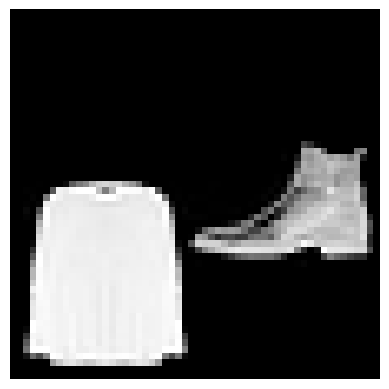

True Vector:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
Predicted Vector:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]


In [41]:


# Function to predict labels for a single image
def predict_image(model, image_tensor, threshold=0.5):
    # Move image to the same device as the model
    image_tensor = image_tensor.to(device)
    
    # Forward pass to get output
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Apply sigmoid since the output layer is linear
    predictions = torch.sigmoid(predictions)
    
    # Apply threshold to each predicted label score
    predicted_labels = (predictions > threshold).float()
    return predicted_labels

# Function to visualize predictions along with images
def visualize_prediction(model, data, index, threshold=0.5):
    image, true_vector = data[index]
    predicted_vector = predict_image(model, image.unsqueeze(0), threshold)
    
    # Show image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Print true and predicted labels
    print("True Vector: ", true_vector.numpy())
    print("Predicted Vector: ", predicted_vector.cpu().numpy()[0])

# Example usage:
visualize_prediction(model, test_dataset, index=0)  # Replace index with any index from your test dataset


accuracy zwykłego modelu w porównaniu do rna - zignoruj to co powyżej

In [53]:
# wystarczy załadować już gotowy model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpatialRelationCNN().to(device)
model.load_state_dict(torch.load('normal_cnn.pth'))

<All keys matched successfully>

In [54]:
# Function to calculate the accuracy of the model
def calculate_accuracy(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).all(dim=1).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

zwykly + szumy

In [55]:
test_images = torch.stack([item[0] for item in test_data])
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])
test_images = add_uniform_noise(test_images)  # Dodawanie szumów do obrazów testowych

test_dataset = TensorDataset(test_images, test_vectors)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, test_loader)
print(f'Accuracy on the test set: {accuracy:.4f}')

Accuracy on the test set: 0.4892


In [56]:
val_images = torch.stack([item[0] for item in val_data])
val_vectors = torch.stack([torch.tensor(item[1]) for item in val_data])
val_images = add_uniform_noise(val_images)  # Dodawanie szumów do obrazów testowych

val_dataset = TensorDataset(val_images, val_vectors)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

accuracy = calculate_accuracy(model, val_loader)
print(f'Accuracy on the validation set: {accuracy:.4f}')

Accuracy on the validation set: 0.4815


koniec zwykly + szumy

zwykly bez szumów

In [57]:
# Calculate and print accuracy for the test set
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Exact Match Test Accuracy: {test_accuracy:.4f}')

Exact Match Test Accuracy: 0.4892


In [58]:
# Calculate and print accuracy for the test set
val_accuracy = calculate_accuracy(model, val_loader)
print(f'Exact Match Validation Accuracy: {val_accuracy:.4f}')

Exact Match Validation Accuracy: 0.4815


koniec zwykly bez szumów